In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans
from torchsummary import summary
from qqdm import qqdm, format_str
import pandas as pd
import os,glob,imageio
import pdb  # use pdb.set_trace() to set breakpoints for debugging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
base_path = r'.'
base_path = r'C:\Users\alwaysmle\Desktop\pytorch\histology-images-query-competition'
query_csv = os.path.join(base_path,  'queries.csv')
train_dir = os.path.join(base_path,  'train', 'train')
test_dir = os.path.join(base_path,  'test', 'test')
combine_dir = os.path.join(base_path,  'combine')

In [3]:
#read test dataset
test_names = glob.glob(os.path.join(test_dir, '*') )
test_numpy = []
test_name = []
for image_path in test_names:
  id_name = image_path[-16:-4]
  im = imageio.imread(image_path)
  test_numpy.append(im)
  test_name.append(id_name)
  print(len(test_numpy))
train_numpy = np.array(test_numpy)
np.save('test',test_numpy)
np.save('test_id',tesn_name)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [ ]:
#read combine dataset
combine_names = glob.glob(os.path.join(combine_dir, '*') )
combine_numpy = []
combine_name = []
for image_path in test_names:
  id_name = image_path[-16:-4]
  im = imageio.imread(image_path)
  combine_numpy.append(im)
  combine_name.append(id_name)
  print(len(combine_numpy))
train_numpy = np.array(test_numpy)
np.save('combine',combine_numpy)
np.save('combine_id',combine_name)

# Loading data

In [4]:
train = np.load('train.npy', allow_pickle=True)
test = np.load('test.npy', allow_pickle=True)
test_id = np.load('test_id.npy', allow_pickle=True)
combine = np.load('combine.npy', allow_pickle=True)
combine_id  = np.load('combine_id.npy', allow_pickle=True)
print(train.shape)
print(test.shape)
print(combine.shape)

(6187, 256, 256, 3)
(3427, 256, 256, 3)
(9614, 256, 256, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [5]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

# Autoencoder

# Models & loss

Lecture video：https://www.youtube.com/watch?v=6W8FqUGYyDo&list=PLJV_el3uVTsOK_ZK5L0Iv_EQoL1JefRL4&index=8

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

In [6]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 64 * 64 * 3), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# maybe it can be smaller
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        start_dim = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(3, start_dim, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.Conv2d(start_dim, start_dim*2, 4, stride=2, padding=1),        
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.Conv2d(start_dim*2, start_dim*4, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.Conv2d(start_dim*4, start_dim*8, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.Conv2d(start_dim*8, start_dim*16, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*16),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(start_dim*16, start_dim*8, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.ConvTranspose2d(start_dim*8, start_dim*4, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.ConvTranspose2d(start_dim*4, start_dim*2, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.ConvTranspose2d(start_dim*2, start_dim, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.ConvTranspose2d(start_dim, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(3),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD


class Resnet(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(Resnet, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)

        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        if x.shape[0] > 1:
            x = self.bn1(self.fc1(x))
        else:
            x = self.fc1(x)
        x = self.relu(x)
        if x.shape[0] > 1:
            x = self.bn2(self.fc2(x))
        else:
            x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3_mu(x)
        return x

    def decode(self, z):
        if z.shape[0] > 1:
            x = self.relu(self.fc_bn4(self.fc4(z)))
            x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        else:
            x = self.relu(self.fc4(z))
            x = self.relu(self.fc5(x)).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=True)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_reconst = self.decode(z)

        return x_reconst


# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [7]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors,train):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        if(train):
          self.transform = transforms.Compose([
                              transforms.Lambda(lambda x: x.to(torch.float32)),
                              transforms.Lambda(lambda x: 2. * x/255. - 1.),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5),
                              # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])
        else:
          self.transform = transforms.Compose([
                              transforms.Lambda(lambda x: x.to(torch.float32)),
                              transforms.Lambda(lambda x: 2. * x/255. - 1.),
                              # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])          
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return index,x

    def __len__(self):
        return len(self.tensors)

# Training

## Initialize
- hyperparameters
- dataloader
- model
- optimizer & loss


In [10]:
# Training hyperparameters
num_epochs = 500
batch_size = 130 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(combine)
train_dataset = CustomTensorDataset(x,train=True)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_data =  torch.from_numpy(test)
test_dataset = CustomTensorDataset(test_data,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=300)

# Model
model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = { 'cnn':conv_autoencoder() }
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

In [11]:

summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             784
              ReLU-2         [-1, 16, 128, 128]               0
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4           [-1, 32, 64, 64]           8,224
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 32, 32]          32,832
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10          [-1, 128, 16, 16]         131,200
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
           Conv2d-13            [-1, 256, 8, 8]         524,544
             ReLU-14            [-1, 25

## Training loop

In [25]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for index,data in train_dataloader:
        #print(data)
        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_mode_start1_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_start1_{}.pt'.format(model_type))




 Iters    Elapsed Time      Speed                                                                                       
 0/500          -             -                                                                                         
Description   0.0% |                                                                                                   | Iters    Elapsed Time      Speed    epoch   loss                                                                       
 1/500  00:00:11<01:36:18  0.09it/s  1/500  0.6094                                                                      
Description   0.2% |                                                                                                   | Iters    Elapsed Time      Speed    epoch   loss                                                                       
 2/500  00:00:22<01:31:21  0.09it/s  2/500  0.3972                                                                      
Description   0.4% |              

Description   3.2% |███                                                                                                | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 17/500  00:02:56<01:23:27  0.10it/s  17/500  0.0135                                                                    
Description   3.4% |███                                                                                                | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 18/500  00:03:06<01:23:15  0.10it/s  18/500  0.0127                                                                    
Description   3.6% |███                                                                                                | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 19/500  00:03:16<01:23:03  0.10it/

Description   6.4% |██████                                                                                             | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 33/500  00:05:41<01:20:38  0.10it/s  33/500  0.0105                                                                    
Description   6.6% |██████                                                                                             | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 34/500  00:05:52<01:20:32  0.10it/s  34/500  0.0104                                                                    
Description   6.8% |██████                                                                                             | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 35/500  00:06:03<01:20:26  0.10it/

Description   9.4% |█████████                                                                                          | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 48/500  00:08:24<01:19:09  0.10it/s  48/500  0.0085                                                                    
Description   9.6% |█████████                                                                                          | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 49/500  00:08:34<01:18:59  0.10it/s  49/500  0.0084                                                                    
Description   9.8% |█████████                                                                                          | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 50/500  00:08:45<01:18:51  0.10it/

Description  15.0% |██████████████                                                                                     | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 76/500  00:13:25<01:14:54  0.09it/s  76/500  0.0066                                                                    
Description  15.2% |███████████████                                                                                    | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 77/500  00:13:36<01:14:43  0.09it/s  77/500  0.0065                                                                    
Description  15.4% |███████████████                                                                                    | Iters     Elapsed Time      Speed    epoch    loss                                                                     
 78/500  00:13:46<01:14:31  0.09it/

Description  20.2% |███████████████████                                                                                |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 102/500  00:18:02<01:10:24  0.09it/s  102/500  0.0066                                                                  
Description  20.4% |████████████████████                                                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 103/500  00:18:13<01:10:15  0.09it/s  103/500  0.0062                                                                  
Description  20.6% |████████████████████                                                                               |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 104/500  00:18:24<01:10:05  0.09it

Description  25.0% |████████████████████████                                                                           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 126/500  00:22:21<01:06:22  0.09it/s  126/500  0.0055                                                                  
Description  25.2% |████████████████████████                                                                           |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 127/500  00:22:32<01:06:12  0.09it/s  127/500  0.0055                                                                  
Description  25.4% |█████████████████████████                                                                          |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 128/500  00:22:43<01:06:02  0.09it

Description  27.4% |███████████████████████████                                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 138/500  00:24:29<01:04:14  0.09it/s  138/500  0.0054                                                                  
Description  27.6% |███████████████████████████                                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 139/500  00:24:39<01:04:03  0.09it/s  139/500  0.0053                                                                  
Description  27.8% |███████████████████████████                                                                        |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 140/500  00:24:50<01:03:52  0.09it

Description  31.8% |███████████████████████████████                                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 160/500  00:28:29<01:00:33  0.09it/s  160/500  0.0052                                                                  
Description  32.0% |███████████████████████████████                                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 161/500  00:28:40<01:00:22  0.09it/s  161/500  0.0050                                                                  
Description  32.2% |███████████████████████████████                                                                    |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 162/500  00:28:51<01:00:12  0.09it

Description  34.0% |█████████████████████████████████                                                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 171/500  00:30:29<00:58:39  0.09it/s  171/500  0.0049                                                                  
Description  34.2% |█████████████████████████████████                                                                  |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 172/500  00:30:40<00:58:28  0.09it/s  172/500  0.0048                                                                  
Description  34.4% |██████████████████████████████████                                                                 |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 173/500  00:30:50<00:58:18  0.09it

Description  38.0% |█████████████████████████████████████                                                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 191/500  00:34:09<00:55:16  0.09it/s  191/500  0.0048                                                                  
Description  38.2% |█████████████████████████████████████                                                              |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 192/500  00:34:21<00:55:06  0.09it/s  192/500  0.0047                                                                  
Description  38.4% |██████████████████████████████████████                                                             |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 193/500  00:34:32<00:54:56  0.09it

Description  40.0% |███████████████████████████████████████                                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 201/500  00:35:59<00:53:31  0.09it/s  201/500  0.0046                                                                  
Description  40.2% |███████████████████████████████████████                                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 202/500  00:36:10<00:53:21  0.09it/s  202/500  0.0046                                                                  
Description  40.4% |███████████████████████████████████████                                                            |  Iters     Elapsed Time      Speed     epoch    loss                                                                   
 203/500  00:36:21<00:53:11  0.09it

KeyboardInterrupt: 

In [12]:
eval_batch_size = 32

# load trained model
checkpoint_path = 'best_mode_start1_cnn.pt'
model = torch.load(checkpoint_path)
model.eval()
torch.save(model.state_dict(), "start1.pt")
model

conv_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTransp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


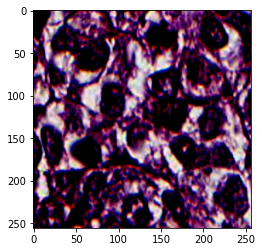

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([130, 3, 256, 256])


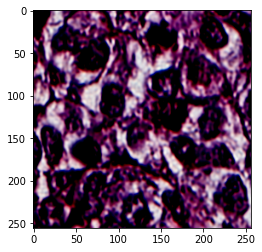

In [13]:
# check the output of decoder 
val_dataset = CustomTensorDataset(x,train=True)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size)
def print_result():
  model.eval()
  val_loss = []
  for _id,data in val_dataloader:
      with torch.no_grad():
          # ===================loading=====================
          if model_type in ['cnn', 'vae', 'resnet', 'unet']:
              img = data.float().cuda()
          elif model_type in ['fcn']:
              img = data.float().cuda()
              img = img.view(img.shape[0], -1)

          # ===================forward=====================
          output = model(img)
          return output,img
output_img,img=  print_result()
img.size()
out_id = 35
plt.imshow(  img[out_id].cpu().permute(1, 2, 0)  )
plt.show()
print(type(output_img),output_img.size())
plt.imshow(  output_img[out_id].cpu().permute(1, 2, 0)  )

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [14]:
#create a encoder to get the feature map of all test images
class conv_encoder(nn.Module):
    def __init__(self):
        super(conv_encoder, self).__init__()
        start_dim = 16
        self.encoder = nn.Sequential(
            nn.Conv2d(3, start_dim, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.Conv2d(start_dim, start_dim*2, 4, stride=2, padding=1),        
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.Conv2d(start_dim*2, start_dim*4, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.Conv2d(start_dim*4, start_dim*8, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.Conv2d(start_dim*8, start_dim*16, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*16),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(start_dim*16, start_dim*8, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*8),
            nn.ConvTranspose2d(start_dim*8, start_dim*4, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*4),
            nn.ConvTranspose2d(start_dim*4, start_dim*2, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim*2),
            nn.ConvTranspose2d(start_dim*2, start_dim, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(start_dim),
            nn.ConvTranspose2d(start_dim, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            nn.BatchNorm2d(3),
        )


    def forward(self, x):
        x = self.encoder(x)
        return x

encoder = conv_encoder() # Our encoder model
encoder.load_state_dict(torch.load('start1.pt'))
device = "cuda"  # GPU device
encoder.to(device)


conv_encoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2

In [15]:
#create feature map of all test image
embedding_dim = (1, 256, 8, 8)
def create_embedding(encoder,  device='cuda'):
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    #print(embedding.size())
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, train_img in test_dataloader:
            #print(batch_idx)
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            embedding = torch.cat((embedding, enc_output), 0)
            #print(batch_idx)
            #print(starembedding)
    # Return the embeddings
    return embedding[1:]
embedding = create_embedding(encoder)

In [16]:
embed_array =  embedding.view(3427,-1).numpy()

In [34]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pca.fit(embed_array)
pca_embed = pca.transform(embed_array)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.03950155 0.01341714 0.0046705  0.00293778 0.00253644 0.00223261
 0.00188299 0.00174831 0.00170883 0.00168631 0.00165496 0.00163413
 0.00161665 0.00160518 0.00158958]
[1339.0868   780.4257   460.45087  365.18393  339.3238   318.35248
  292.3655   281.7155   278.51648  276.67523  274.09116  272.36084
  270.9003   269.93735  268.6225 ]


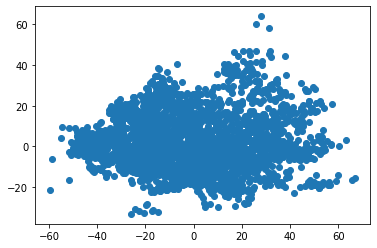

In [35]:
plt.scatter(pca_embed[:,0],pca_embed[:,1])

In [191]:
#check silhouette score of k mean
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,]
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(embed_array)
  cluster_labels = kmeans.labels_
 # silhouette score
  silhouette_avg.append(silhouette_score(pca_embed, cluster_labels))
  
plt.plot(range_n_clusters,silhouette_avg,'x-')
plt.xlabel('alues of K') 
plt.ylabel('silhouette score')
plt.title('shouette analysis For Optimal k')
plt.show()

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

C:\Users\alwaysmle\anaconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=14.
  warnings.warn(


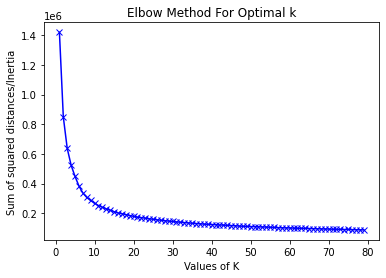

In [18]:
#check elbow method for optimal k
Sum_of_squared_distances = []
K = range(1,80)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(pca_embed)
  Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [268]:
from sklearn import cluster, datasets
# KMeans 演算法
kmeans_fit = cluster.KMeans(n_clusters = 25).fit(pca_embed)
# 印出分群結果
cluster_labels = kmeans_fit.labels_
print("分群結果：")
print(cluster_labels)
print("---")
cluster_labels.shape



分群結果：
[ 8 24 16 ... 21 19  8]
---


(3427,)

In [36]:
#get similarity of two query, target can be pca_embeded or original image
import csv
def getSimilarityMatrix(a1,a2):
    cos_sim = np.dot(a1,a2) / (np.linalg.norm(a1) * np.linalg.norm(a2))
    return cos_sim
  
query_csv_file = pd.read_csv(query_csv,header=None)
sim_arr = []
id_1 = []
id_2 = []
for i in query_csv_file.values:
  img1 = i[0][:-4]
  img2 = i[1][:-4]
  img1_id = np.where(img1==test_id)
  img2_id = np.where(img2==test_id)
  sim_arr.append(getSimilarityMatrix(pca_embed[img1_id].flatten(),pca_embed[img2_id].flatten()))
  id_1.append(img1_id)
  id_2.append(img2_id)

In [37]:
sim_arr

[0.5478209,
 0.81991214,
 -0.4788494,
 -0.7563212,
 -0.26890618,
 -0.05258503,
 -0.0130357165,
 -0.18759748,
 0.36937985,
 0.2953021,
 0.76574504,
 -0.35903198,
 0.21897227,
 -0.79971737,
 0.2691539,
 -0.07103426,
 -0.63220316,
 -0.12888792,
 -0.69139016,
 0.5887783,
 0.10202292,
 0.7600466,
 -0.16982816,
 -0.26231992,
 -0.37802893,
 0.47306675,
 -0.08968051,
 0.4124759,
 0.54740393,
 0.5855643,
 -0.3249087,
 -0.47963527,
 0.41304484,
 0.12521584,
 0.5951251,
 0.8093348,
 -0.3678147,
 0.8299505,
 0.3578478,
 -0.6226815,
 -0.23620833,
 -0.42745256,
 -0.105624385,
 -0.030313537,
 0.83758396,
 -0.14992774,
 -0.12393554,
 -0.004476717,
 0.046704635,
 0.39745194,
 0.30811507,
 0.37996808,
 -0.07366538,
 0.1302142,
 0.49557158,
 -0.64031935,
 0.20622678,
 0.6248638,
 0.51080143,
 0.50207156,
 0.6023053,
 -0.38840368,
 0.6978921,
 0.5274615,
 0.35337988,
 0.63725895,
 -0.15086107,
 0.8496782,
 0.7020036,
 -0.29991943,
 -0.54248524,
 -0.43900087,
 0.82577705,
 -0.6764893,
 -0.43742847,
 0.3116

In [269]:
#use k mean to differentiate
label_1 = 0
label_0 = 0
label_1_id = []
sim_output=sim_arr.copy()
for i in range(len(sim_output)):
  if(cluster_labels[id_1[i]]==cluster_labels[id_2[i]]):
    sim_output[i] = 1
    label_1 += 1
    label_1_id.append([id_1[i][0][0],id_2[i][0][0]])
  else:
    sim_output[i] = 0
    label_0 += 1
    
print(label_0/(label_1+label_0))

0.9507298170939827


In [158]:
#get similarity of all img in test to random 200 images
similar_arr = []
count = 0
for i in range(len(embedding)):
  temp = []
  for j in np.random.randint(3427, size=200):
    temp.append(getSimilarityMatrix(embedding[i].flatten(),embedding[j].flatten()))
  similar_arr.append(np.quantile(temp, 0.9))

In [28]:
#if similarity is larger than 0.8 of random images , output 1
sim_output=sim_arr.copy()
label_1 = 0
label_0 = 0
label_1_id = []
#median = np.quantile(sim_arr, 0.75)
for i in range(len(sim_output)):
  if(sim_output[i]>(similar_arr[id_1[i][0][0]])):
    sim_output[i] = 1
    label_1 += 1
    label_1_id.append([id_1[i][0][0],id_2[i][0][0]])
  else:
    sim_output[i] = 0
    label_0 += 1
print(label_0/(label_1+label_0))

NameError: name 'similar_arr' is not defined

In [43]:
#if similarity is larger median or other percent
label_1 = 0
label_0 = 0
low = 0.62
high = 1
label_1_id = []
sim_output=sim_arr.copy()
median_low = np.quantile(sim_arr,low)
median_high =  np.quantile(sim_arr,high)
for i in range(len(sim_output)):
  if(sim_output[i]>median_low and sim_output[i]<median_high):
    sim_output[i] = 1
    label_1_id.append([id_1[i][0][0],id_2[i][0][0]])
  else:
    sim_output[i] = 0
print(median_low)


0.1711579889059067


In [45]:
#if similarity is larger specific vale
sim_output=sim_arr.copy()
low = 0.98
high = 1.1
label_1 = 0
label_0 = 0
label_1_id = []
for i in range(len(sim_output)):
  if(sim_output[i]>low and sim_output[i]<high):
    sim_output[i] = 1
    label_1_id.append([id_1[i][0][0],id_2[i][0][0]])
    label_1 += 1
  else:
    sim_output[i] = 0
    label_0 += 1
print(label_0/(label_1+label_0))

0.9996386050153593


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

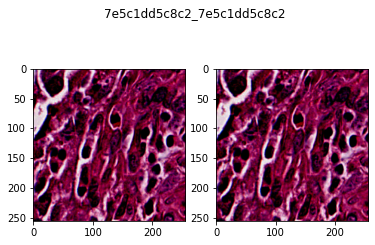

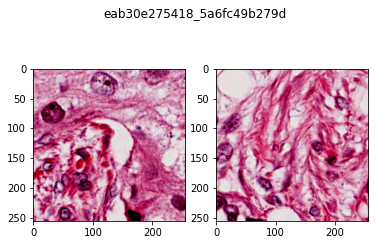

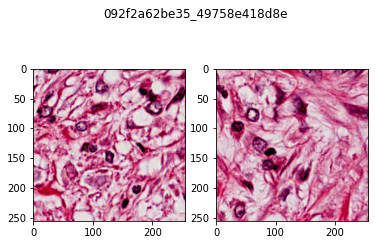

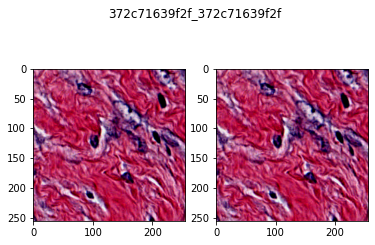

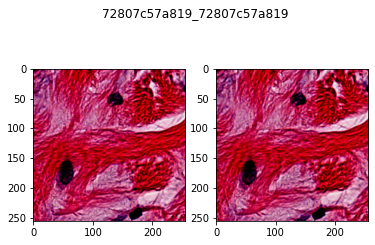

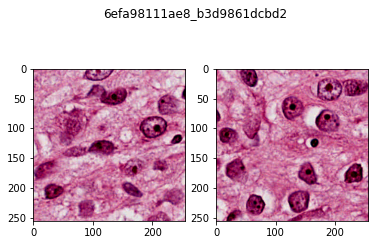

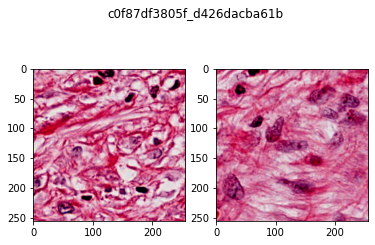

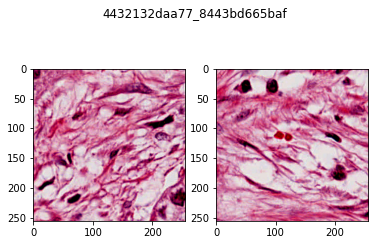

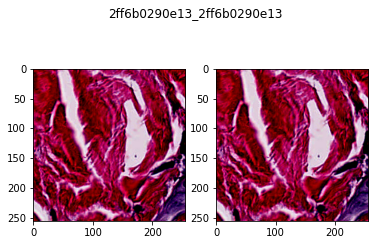

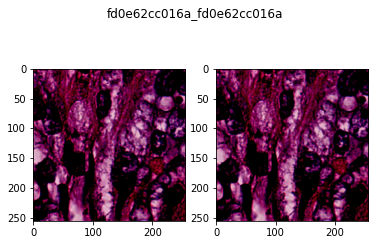

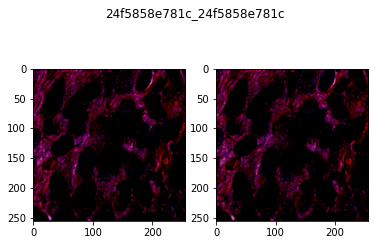

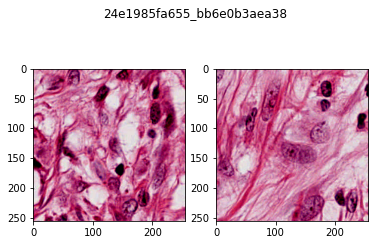

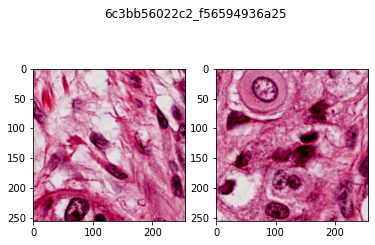

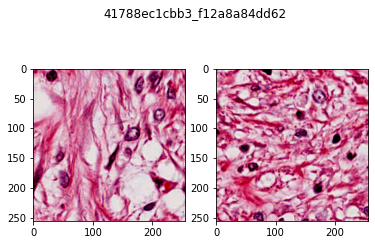

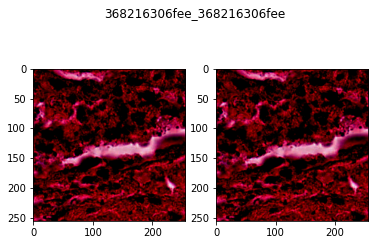

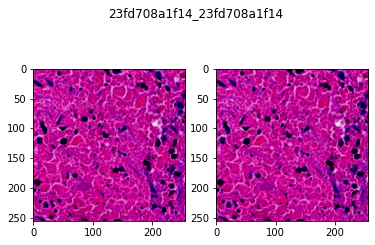

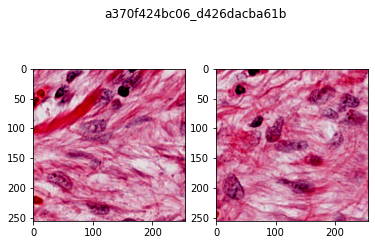

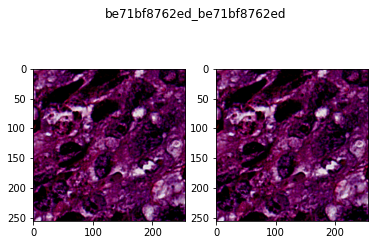

In [46]:
#show label 1 image
max_display = 80
count = 0
for i in range(len(label_1_id)):
  #plt.imshow(  img[out_id].cpu().permute(1, 2, 0)  )
  fig, axs = plt.subplots(1,2)
  fig.suptitle(str(test_id[label_1_id[i][0]])+'_'+str(test_id[label_1_id[i][1]]))
  axs[0].imshow(  test_dataset[label_1_id[i][0]][1].cpu().permute(1, 2, 0)  )
  axs[1].imshow(  test_dataset[label_1_id[i][1]][1].cpu().permute(1, 2, 0)  )
  count += 1
  if (max_display==count):
    break

In [44]:
import csv
csv_name = 'sim12.csv'
count = 0
with open(csv_name, 'w', newline='') as result:
  writer = csv.writer(result)
  writer.writerow(['query', 'prediction'])
  for i in query_csv_file.values:
    writer.writerow([i[0][:-4]+'_'+i[1][:-4], sim_output[count]])
    count+=1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929
3930
3931
3932
3933
3934
3935
3936
3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947
3948
3949
3950
3951
3952
3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966
3967
3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978
3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112


7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813


11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923
11924
11925
11926
11927
11928
11929
11930
11931
11932
11933
11934
11935
11936
11937
11938
11939
11940
11941
11942
11943
11944
11945
11946
11947
11948
11949
11950
11951
11952
11953
11954
11955
11956
11957
11958
11959
11960
11961
11962
11963
11964
11965
11966
11967
11968
11969
11970
11971
11972
11973
11974
11975
11976
11977
11978
11979
11980
11981
11982
11983
11984
11985
11986
11987
11988
11989
11990
11991
11992
11993
11994
11995
11996
11997
11998
11999
12000
12001
12002
12003
12004
12005
12006
12007
12008
12009
12010
12011
12012
12013
12014
12015
12016
12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
1207

15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945
15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957
15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972
15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985
15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997
15998
15999
16000
16001
16002
16003
16004
16005
16006
16007
16008
16009
16010
16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023
16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036
16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
1607

19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
2007

23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
2404

27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
2807

32318
32319
32320
32321
32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
32336
32337
32338
32339
32340
32341
32342
32343
32344
32345
32346
32347
32348
32349
32350
32351
32352
32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365
32366
32367
32368
32369
32370
32371
32372
32373
32374
32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386
32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401
32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412
32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426
32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
32437
32438
32439
32440
32441
32442
32443
32444
32445
32446
32447
32448
32449
32450
32451
32452
32453
32454
32455
32456
32457
32458
32459
32460
32461
32462
32463
32464
32465
32466
32467
32468
32469
32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483
3248

36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
36448
36449
36450
36451
36452
36453
36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469
36470
36471
36472
36473
36474
36475
36476
36477
36478
36479
36480
36481
36482
36483
36484
36485
36486
36487
36488
36489
36490
36491
36492
36493
36494
36495
36496
36497
36498
36499
36500
36501
36502
36503
36504
36505
36506
36507
36508
36509
36510
36511
36512
36513
36514
36515
36516
36517
36518
36519
36520
36521
36522
36523
36524
36525
36526
36527
36528
36529
36530
36531
36532
36533
36534
36535
36536
36537
36538
36539
36540
36541
36542
36543
36544
36545
36546
36547
36548
36549
36550
36551
36552
36553
36554
36555
36556
36557
36558
36559
36560
36561
36562
36563
36564
36565
36566
36567
36568
36569
36570
36571
36572
36573
36574
3657

40608
40609
40610
40611
40612
40613
40614
40615
40616
40617
40618
40619
40620
40621
40622
40623
40624
40625
40626
40627
40628
40629
40630
40631
40632
40633
40634
40635
40636
40637
40638
40639
40640
40641
40642
40643
40644
40645
40646
40647
40648
40649
40650
40651
40652
40653
40654
40655
40656
40657
40658
40659
40660
40661
40662
40663
40664
40665
40666
40667
40668
40669
40670
40671
40672
40673
40674
40675
40676
40677
40678
40679
40680
40681
40682
40683
40684
40685
40686
40687
40688
40689
40690
40691
40692
40693
40694
40695
40696
40697
40698
40699
40700
40701
40702
40703
40704
40705
40706
40707
40708
40709
40710
40711
40712
40713
40714
40715
40716
40717
40718
40719
40720
40721
40722
40723
40724
40725
40726
40727
40728
40729
40730
40731
40732
40733
40734
40735
40736
40737
40738
40739
40740
40741
40742
40743
40744
40745
40746
40747
40748
40749
40750
40751
40752
40753
40754
40755
40756
40757
40758
40759
40760
40761
40762
40763
40764
40765
40766
40767
40768
40769
40770
40771
40772
40773
4077

44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
44529
44530
44531
44532
44533
44534
44535
44536
44537
44538
44539
44540
44541
44542
44543
44544
44545
44546
44547
44548
44549
44550
44551
44552
44553
44554
44555
44556
44557
44558
44559
44560
44561
44562
44563
44564
44565
44566
44567
44568
44569
44570
44571
44572
44573
44574
44575
44576
44577
44578
44579
44580
44581
44582
44583
44584
44585
44586
44587
44588
44589
44590
44591
44592
44593
44594
44595
44596
44597
44598
44599
44600
44601
44602
44603
44604
44605
44606
44607
44608
44609
44610
44611
44612
44613
44614
44615
44616
44617
44618
44619
44620
44621
44622
44623
44624
44625
44626
44627
44628
44629
44630
4463

49068
49069
49070
49071
49072
49073
49074
49075
49076
49077
49078
49079
49080
49081
49082
49083
49084
49085
49086
49087
49088
49089
49090
49091
49092
49093
49094
49095
49096
49097
49098
49099
49100
49101
49102
49103
49104
49105
49106
49107
49108
49109
49110
49111
49112
49113
49114
49115
49116
49117
49118
49119
49120
49121
49122
49123
49124
49125
49126
49127
49128
49129
49130
49131
49132
49133
49134
49135
49136
49137
49138
49139
49140
49141
49142
49143
49144
49145
49146
49147
49148
49149
49150
49151
49152
49153
49154
49155
49156
49157
49158
49159
49160
49161
49162
49163
49164
49165
49166
49167
49168
49169
49170
49171
49172
49173
49174
49175
49176
49177
49178
49179
49180
49181
49182
49183
49184
49185
49186
49187
49188
49189
49190
49191
49192
49193
49194
49195
49196
49197
49198
49199
49200
49201
49202
49203
49204
49205
49206
49207
49208
49209
49210
49211
49212
49213
49214
49215
49216
49217
49218
49219
49220
49221
49222
49223
49224
49225
49226
49227
49228
49229
49230
49231
49232
49233
4923

In [7]:
combine_data =  torch.from_numpy(combine)
combine_dataset = CustomTensorDataset(combine_data,train=False)
combine_dataloader = DataLoader(combine_dataset, batch_size=300)

In [15]:


#create feature map of all test image
embedding_dim = (1, 256, 8, 8)
def create_embedding(encoder,  device='cuda'):
    encoder.eval()
    # Just a place holder for our 0th image embedding.
    embedding = torch.randn(embedding_dim)
    #print(embedding.size())
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, train_img in combine_dataloader:
            #print(batch_idx)
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            embedding = torch.cat((embedding, enc_output), 0)
            #print(batch_idx)
            #print(starembedding)
    # Return the embeddings
    return embedding[1:]
embedding = create_embedding(encoder)
embed_array =  embedding.view(embedding.size()[0],-1).numpy()

In [16]:
embed_array =  embedding.view(embedding.size()[0],-1).numpy()

In [17]:

pca = PCA(n_components=8)
pca.fit(embed_array)
pca_embed = pca.transform(embed_array)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.03880402 0.01196069 0.00995491 0.0056342  0.00296869 0.00222545
 0.00184127 0.00141995]
[2284.5469  1268.3523  1157.1251   870.5185   631.894    547.1053
  497.64597  437.0162 ]


In [18]:
#get similarity of two query, target can be pca_embeded or original image
import csv
def getSimilarityMatrix(a1,a2):
    cos_sim = np.dot(a1,a2) / (np.linalg.norm(a1) * np.linalg.norm(a2))
    return cos_sim
  
query_csv_file = pd.read_csv(query_csv,header=None)
sim_arr = []
id_1 = []
id_2 = []
label=[]
count_1 = 0
count_0 = 0
check_repeat = np.zeros((len(embedding),len(embedding)))
for i in range(len(embedding)):
  temp = []
  print(i)
  for j in np.random.randint(embedding.size()[0], size=5000):
    img1_id = i
    img2_id = j
    sim = getSimilarityMatrix(pca_embed[i].flatten(),pca_embed[j].flatten())
    if(sim>0.99 and i!=j and check_repeat[i][j]==0 and check_repeat[j][i]==0):
      id_1.append(img1_id)
      id_2.append(img2_id)
      label.append(1)
      count_1+=1
      check_repeat[i][j]=1
      check_repeat[j][i]=1
    elif(sim<-0.97 and check_repeat[i][j]==0 and check_repeat[j][i]==0):
      id_1.append(img1_id)
      id_2.append(img2_id)
      label.append(0)
      count_0+=1  
      check_repeat[i][j]=1
      check_repeat[j][i]=1
np.save('id_1',id_1)
np.save('id_2',id_2)
np.save('label_out',label)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341


6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980


8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622


In [19]:
print(count_0)
print(count_1) 

9597
13472


In [20]:
np.save('id_1',id_1)
np.save('id_2',id_2)
np.save('label',label)
np.save('count_0',count_0)
np.save('count_1',count_1)

In [26]:
id_1 = np.load('id_1.npy')
id_2 = np.load('id_2.npy')
label = np.load('label.npy')
count_0 = np.load('count_0.npy')
count_1 = np.load('count_1.npy')

In [27]:
id_1

array([   0,    2,    2, ..., 9613, 9613, 9613])

NameError: name 'combine_dataset' is not defined

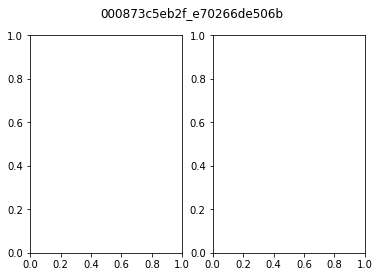

In [28]:
#show label 1 image
max_display = 100
count = 0
for i in range(count_1):
  #plt.imshow(  img[out_id].cpu().permute(1, 2, 0)  )
  if(label[i]==1):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(str(combine_id[id_1[i]])+'_'+str(combine_id[id_2[i]]))
    axs[0].imshow(  combine_dataset[id_1[i]][1].cpu().permute(1, 2, 0)  )
    axs[1].imshow(  combine_dataset[id_2[i]][1].cpu().permute(1, 2, 0)  )
    count += 1
    if (max_display==count):
      break

In [25]:
#show label 0 image
max_display = 100
count = 0
for i in range(count_1):
  #plt.imshow(  img[out_id].cpu().permute(1, 2, 0)  )
  if(label[i]==0):
    fig, axs = plt.subplots(1,2)
    fig.suptitle(str(combine_id[id_1[i]])+'_'+str(combine_id[id_2[i]]))
    axs[0].imshow(  combine_dataset[id_1[i]][1].cpu().permute(1, 2, 0)  )
    axs[1].imshow(  combine_dataset[id_2[i]][1].cpu().permute(1, 2, 0)  )
    count += 1
    if (max_display==count):
      break

NameError: name 'count_1' is not defined

In [7]:
class CustomTensorDataset2(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors,train,id1,id2,label=None):
        self.tensors = tensors
        self.label = label
        self.id1 = id1
        self.id2 = id2
        self.train = train
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        if(train):
          self.transform = transforms.Compose([
                              transforms.Lambda(lambda x: x.to(torch.float32)),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5),
                              ])
        else:
          self.transform = transforms.Compose([
                              transforms.Lambda(lambda x: x.to(torch.float32)),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ])          
        
    def __getitem__(self, index):
        x1 = self.tensors[self.id1[index]]
        x2 = self.tensors[self.id2[index]]
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x1 = self.transform(x1)
            x2 = self.transform(x1)
        if (self.train):
          return index,x1,x2,self.label[index]
        else:
          return index,x1,x2

    def __len__(self):
        return len(self.id1)

In [12]:
num_epochs = 50
batch_size = 32 # medium: smaller batchsize
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(combine)
train_dataset = CustomTensorDataset2(x,True,id_1,id_2,label)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)


In [13]:
len(id_1)

23069

In [8]:
#Different network structures, the commented out are the different experimenting structures
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Koch et al.
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

        # VGG16
        # # dataiter = iter(train_loader)
        # # img1, img2, label = dataiter.next()
        # # print(img1.shape)
        # self.conv11 = nn.Conv2d(1, 64, 3) 
        # self.conv12 = nn.Conv2d(64, 64, 3)  
        # self.conv21 = nn.Conv2d(64, 128, 3)
        # self.conv22 = nn.Conv2d(128, 128, 3)
        # self.conv31 = nn.Conv2d(128, 256, 3) 
        # self.conv32 = nn.Conv2d(256, 256, 3)  
        # self.conv33 = nn.Conv2d(256, 256, 3)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(256 * 8 * 8, 4096)
        # self.fc2 = nn.Linear(4096, 4096)
        # self.fcOut = nn.Linear(4096, 1)
        # self.sigmoid = nn.Sigmoid()
        # # x = self.conv11(img1)
        # # x = self.conv12(x)
        # # x = self.pool(x)
        # # x = self.conv21(x)
        # # x = self.conv22(x)
        # # x = self.pool(x)
        # # x = self.conv31(x)
        # # x = self.conv32(x)
        # # x = self.conv33(x)
        # # x = self.pool(x)
        # # print(x.shape)
    
    def convs(self, x):

        # Koch et al.
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x

        # VGG16
        # x = F.relu(self.conv11(x))
        # x = F.relu(self.conv12(x))
        # x = F.max_pool2d(x, (2,2))
        # x = F.relu(self.conv21(x))
        # x = F.relu(self.conv22(x))
        # x = F.max_pool2d(x, (2,2))
        # x = F.relu(self.conv31(x))
        # x = F.relu(self.conv32(x))
        # x = F.relu(self.conv33(x))
        # x = F.max_pool2d(x, (2,2))
        # return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)

        # Koch et al.
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))

        # VGG16
        # x1 = x1.view(-1, 256 * 8 * 8)
        # x1 = self.fc1(x1)
        # x1 = self.sigmoid(self.fc2(x1))
        
        x2 = self.convs(x2)

        # Koch et al.
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))

        # VGG16
        # x2 = x2.view(-1, 256 * 8 * 8)
        # x2 = self.fc1(x2)
        # x2 = self.sigmoid(self.fc2(x2))

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models

class SiameseNetwork(nn.Module):
    def __init__(self, backbone="efficientnet_b0"):
        '''
        Creates a siamese network with a network from torchvision.models as backbone.
            Parameters:
                    backbone (str): Options of the backbone networks can be found at https://pytorch.org/vision/stable/models.html
        '''

        super().__init__()
        
#        self.conv1 = nn.Conv2d(3, 64, 10) 
#        self.conv2 = nn.Conv2d(64, 128, 7)  
#        self.conv3 = nn.Conv2d(128, 128, 4)
#        self.conv4 = nn.Conv2d(128, 256, 4)
#        self.bn1 = nn.BatchNorm2d(64)
#        self.bn2 = nn.BatchNorm2d(128)
#        self.bn3 = nn.BatchNorm2d(128)
#        self.bn4 = nn.BatchNorm2d(256)
#        self.dropout1 = nn.Dropout(0.1)
#        self.dropout2 = nn.Dropout(0.5)
#        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
#        self.fcOut = nn.Linear(4096, 1)
#        self.sigmoid = nn.Sigmoid()
#        
#        if backbone not in models.__dict__:
#            raise Exception("No model named {} exists in torchvision.models.".format(backbone))

        # Create a backbone network from the pretrained models provided in torchvision.models 
        self.backbone = models.__dict__[backbone](pretrained=True, progress=True)
        #for param in  self.backbone.features.parameters():
        #    param.requires_grad = False
        # Get the number of features that are outputted by the last layer of backbone network.
        out_features = list(self.backbone.modules())[-1].out_features

        # Create an MLP (multi-layer perceptron) as the classification head. 
        # Classifies if provided combined feature vector of the 2 images represent same player or different.
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),

            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
    
    def convs(self, x):

        # Koch et al.
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x
#    def forward(self, x1, x2):
#        x1 = self.convs(x1)
#
#        # Koch et al.
#        x1 = x1.view(-1, 256 * 6 * 6)
#        x1 = self.sigmoid(self.fc1(x1))
#
#        # VGG16
#        # x1 = x1.view(-1, 256 * 8 * 8)
#        # x1 = self.fc1(x1)
#        # x1 = self.sigmoid(self.fc2(x1))
#        
#        x2 = self.convs(x2)
#
#        # Koch et al.
#        x2 = x2.view(-1, 256 * 6 * 6)
#        x2 = self.sigmoid(self.fc1(x2))
#
#        # VGG16
#        # x2 = x2.view(-1, 256 * 8 * 8)
#        # x2 = self.fc1(x2)
#        # x2 = self.sigmoid(self.fc2(x2))
#
#        x = torch.abs(x1 - x2)
#        print(x.size())
#        x = self.fcOut(x)
#        print(x.size())
#        return x
      
    def forward(self, img1, img2):
        '''
        Returns the similarity value between two images.
            Parameters:
                    img1 (torch.Tensor): shape=[b, 3, 224, 224]
                    img2 (torch.Tensor): shape=[b, 3, 224, 224]
            where b = batch size
            Returns:
                    output (torch.Tensor): shape=[b, 1], Similarity of each pair of images
        '''

        # Pass the both images through the backbone network to get their seperate feature vectors
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)
        
        # Multiply (element-wise) the feature vectors of the two images together, 
        # to generate a combined feature vector representing the similarity between the two.
        combined_features = feat1 * feat2

        # Pass the combined feature vector through classification head to get similarity value in the range of 0 to 1.
        output = self.cls_head(combined_features)
        return output
      
model = SiameseNetwork()
device='cuda'
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=10**-4)
#weight_loss = torch.cuda.FloatTensor([count_0/count_1])
#print(weight_loss)
criterion = torch.nn.BCELoss()
summary(model,[(3,256,256),(3,256,256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              SiLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              SiLU-6         [-1, 32, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]             512
      BatchNorm2d-14         [-1, 16, 1

In [14]:
count_0/count_1

0.7123663895486936

In [15]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for index,data1,data2,label in train_dataloader:
        #print(data)
        # ===================loading=====================

        img1 = data1.float().cuda()
        img2 = data2.float().cuda()
        # ===================forward=====================
        output = model(img1,img2)
        loss = criterion(output.squeeze(), label.to(torch.float32).cuda())

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'second{}.pt'.format('eff'))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_second{}.pt'.format('eff'))




 Iters    Elapsed Time      Speed                                                                                       
 0/50           -             -                                                                                         
Description   0.0% |                                                                                                   | Iters    Elapsed Time      Speed    epoch   loss                                                                       
 1/50   00:03:31<02:52:58  0.00it/s  1/50   0.5299                                                                      
Description   2.0% |█                                                                                                  | Iters    Elapsed Time      Speed    epoch   loss                                                                       
 2/50   00:07:02<02:49:09  0.00it/s  2/50   0.4483                                                                      
Description   4.0% |███           

KeyboardInterrupt: 

In [10]:
query_csv_file = pd.read_csv(query_csv,header=None)
sim_arr = []
outid_1 = []
outid_2 = []
for i in query_csv_file.values:
  img1 = i[0][:-4]
  img2 = i[1][:-4]
  out1 = np.where(img1==test_id)[0][0]
  out2 = np.where(img2==test_id)[0][0]
  #sim_arr.append(getSimilarityMatrix(pca_embed[img1_id].flatten(),pca_embed[img2_id].flatten()))
  outid_1.append(out1)
  outid_2.append(out2)
outid_1=np.array(outid_1)
outid_2=np.array(outid_2)
test_data =  torch.from_numpy(test)
test_dataset = CustomTensorDataset2(test_data,False,outid_1,outid_2)
test_dataloader = DataLoader(test_dataset, batch_size=400)

In [11]:
model = torch.load('last_secondeff.pt')

In [12]:
first = (1,1)
first_arr = torch.randn(first)
with torch.no_grad():
    for batch_idx, test_img1,test_img2 in test_dataloader:
        #print(batch_idx)
        test_img1 = test_img1.float().cuda()
        test_img2 = test_img2.float().cuda()
        test_output = model(test_img1,test_img2).cpu()
        first_arr = torch.cat((first_arr, test_output), 0)
first_arr = first_arr[1:]

In [18]:
first_arr.size()
out_arr = first_arr.squeeze().numpy()
len(out_arr)

49807

In [24]:
out_arr

array([0.93390894, 0.516733  , 0.97720236, ..., 0.95522094, 0.95090604,
       0.89115304], dtype=float32)

In [22]:
out_arr = first_arr.squeeze().numpy()
#if similarity is larger specific vale
sim_output=np.zeros(len(out_arr))
low = 0.8
high = 1.1
label_1 = 0
label_0 = 0
label_1_id = []
for i in range(len(sim_output)):
  if(out_arr[i]>low and out_arr[i]<high):
    sim_output[i] = 1
    #label_1_id.append([id_1[i][0][0],id_2[i][0][0]])
    label_1 += 1
  else:
    sim_output[i] = 0
    label_0 += 1
print(label_0/(label_1+label_0))

0.6446684201015922


In [23]:
import csv
csv_name = 'sim11.csv'
count = 0
with open(csv_name, 'w', newline='') as result:
  writer = csv.writer(result)
  writer.writerow(['query', 'prediction'])
  for i in query_csv_file.values:
    writer.writerow([i[0][:-4]+'_'+i[1][:-4], sim_output[count]])
    count+=1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666


7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490
7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591


11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
1160

15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908
15909
15910
15911
15912
15913
15914
15915
15916
15917
15918
15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933
15934
1593

19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
1996

23490
23491
23492
23493
23494
23495
23496
23497
23498
23499
23500
23501
23502
23503
23504
23505
23506
23507
23508
23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521
23522
23523
23524
23525
23526
23527
23528
23529
23530
23531
23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
2365

27720
27721
27722
27723
27724
27725
27726
27727
27728
27729
27730
27731
27732
27733
27734
27735
27736
27737
27738
27739
27740
27741
27742
27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
2788

31295
31296
31297
31298
31299
31300
31301
31302
31303
31304
31305
31306
31307
31308
31309
31310
31311
31312
31313
31314
31315
31316
31317
31318
31319
31320
31321
31322
31323
31324
31325
31326
31327
31328
31329
31330
31331
31332
31333
31334
31335
31336
31337
31338
31339
31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
31352
31353
31354
31355
31356
31357
31358
31359
31360
31361
31362
31363
31364
31365
31366
31367
31368
31369
31370
31371
31372
31373
31374
31375
31376
31377
31378
31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390
31391
31392
31393
31394
31395
31396
31397
31398
31399
31400
31401
31402
31403
31404
31405
31406
31407
31408
31409
31410
31411
31412
31413
31414
31415
31416
31417
31418
31419
31420
31421
31422
31423
31424
31425
31426
31427
31428
31429
31430
31431
31432
31433
31434
31435
31436
31437
31438
31439
31440
31441
31442
31443
31444
31445
31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456
31457
31458
31459
31460
3146

34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
3501

38793
38794
38795
38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
38901
38902
38903
38904
38905
38906
38907
38908
38909
38910
38911
38912
38913
38914
38915
38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957
38958
3895

42739
42740
42741
42742
42743
42744
42745
42746
42747
42748
42749
42750
42751
42752
42753
42754
42755
42756
42757
42758
42759
42760
42761
42762
42763
42764
42765
42766
42767
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
42853
42854
42855
42856
42857
42858
42859
42860
42861
42862
42863
42864
42865
42866
42867
42868
42869
42870
42871
42872
42873
42874
42875
42876
42877
42878
42879
42880
42881
42882
42883
42884
42885
42886
42887
42888
42889
42890
42891
42892
42893
42894
42895
42896
42897
42898
42899
42900
42901
42902
42903
42904
4290

46201
46202
46203
46204
46205
46206
46207
46208
46209
46210
46211
46212
46213
46214
46215
46216
46217
46218
46219
46220
46221
46222
46223
46224
46225
46226
46227
46228
46229
46230
46231
46232
46233
46234
46235
46236
46237
46238
46239
46240
46241
46242
46243
46244
46245
46246
46247
46248
46249
46250
46251
46252
46253
46254
46255
46256
46257
46258
46259
46260
46261
46262
46263
46264
46265
46266
46267
46268
46269
46270
46271
46272
46273
46274
46275
46276
46277
46278
46279
46280
46281
46282
46283
46284
46285
46286
46287
46288
46289
46290
46291
46292
46293
46294
46295
46296
46297
46298
46299
46300
46301
46302
46303
46304
46305
46306
46307
46308
46309
46310
46311
46312
46313
46314
46315
46316
46317
46318
46319
46320
46321
46322
46323
46324
46325
46326
46327
46328
46329
46330
46331
46332
46333
46334
46335
46336
46337
46338
46339
46340
46341
46342
46343
46344
46345
46346
46347
46348
46349
46350
46351
46352
46353
46354
46355
46356
46357
46358
46359
46360
46361
46362
46363
46364
46365
46366
4636

49718
49719
49720
49721
49722
49723
49724
49725
49726
49727
49728
49729
49730
49731
49732
49733
49734
49735
49736
49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
49788
49789
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
49802
49803
49804
49805
49806
49807


In [26]:
del test_img2
torch.cuda.empty_cache()

In [126]:
del model
del optimizer
del loss
torch.cuda.empty_cache()

In [43]:
loss = criterion(output.squeeze(), label.to(torch.float32).cuda())

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([512])) is deprecated. Please ensure they have the same size.

In [36]:
output.squeeze()

tensor([-0.0062, -0.0058, -0.0066, -0.0055, -0.0055, -0.0067, -0.0055, -0.0057,
        -0.0064, -0.0058, -0.0053, -0.0057, -0.0061, -0.0047, -0.0067, -0.0057,
        -0.0056, -0.0057, -0.0056, -0.0060, -0.0060, -0.0057, -0.0059, -0.0055,
        -0.0052, -0.0056, -0.0056, -0.0054, -0.0059, -0.0055, -0.0054, -0.0059,
        -0.0060, -0.0068, -0.0050, -0.0065, -0.0062, -0.0056, -0.0055, -0.0050,
        -0.0056, -0.0058, -0.0065, -0.0060, -0.0063, -0.0055, -0.0052, -0.0046,
        -0.0047, -0.0060, -0.0056, -0.0056, -0.0052, -0.0060, -0.0056, -0.0055,
        -0.0062, -0.0055, -0.0047, -0.0058, -0.0055, -0.0050, -0.0064, -0.0076,
        -0.0049, -0.0059, -0.0056, -0.0054, -0.0060, -0.0058, -0.0054, -0.0055,
        -0.0057, -0.0057, -0.0060, -0.0054, -0.0051, -0.0053, -0.0061, -0.0054,
        -0.0059, -0.0046, -0.0062, -0.0059, -0.0059, -0.0063, -0.0055, -0.0062,
        -0.0050, -0.0060, -0.0056, -0.0055, -0.0055, -0.0052, -0.0050, -0.0056,
        -0.0061, -0.0056, -0.0054, -0.00